In [72]:
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%time

Wall time: 0 ns


## Preliminary Steps ##

##### 1. Merge Dataset to form one DataFrame #####
##### 2. Assign Game ID to each DataFrame before Merge #####
##### 3. Subset data for 300 frames (12 seconds) leading to a shot #####

In [156]:
############ Merge Dataset to form one DataFrame ##########

# set up initial path to data
DATADIR = r'C:\Users\Home\Documents\Man City1\sample-data-master\data'
game_id2 = 2 # let's look at sample match 2
game_id1 = 1 # let's look at sample match 1

# read in the event data
events1 = mio.read_event_data(DATADIR,game_id1)
events1['game_id']=1

# Get all shots
shots1 = events1[events1['Type']=='SHOT']

### Locate the shots and mark them as end of sequence ###
shots1['shot_id_END']=shots1.index

### Now reset the index to provide a sequence identifier ###
shots1=shots1.reset_index(drop=True)
shots1['shots_sequence_id']=shots1.index

first_max=max(shots1['shots_sequence_id'])+1


### Look at previous 12 seconds ###
shots1['shot_id_START']=shots1['End Frame']-300

#### Get all the frame IDs to subset Tracking Data Frame #####

zipped = zip(shots1['shots_sequence_id'],shots1['shot_id_START'], shots1['End Frame'])

dff = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                   columns=['shots_sequence_id','shotids'])
shot_sequence_frames=dff['shotids'].to_list()

events_shot1=events1[events1['Start Frame'].isin(shot_sequence_frames)]
events_shot1['shotids']=events_shot1['Start Frame']
events_shot1=pd.merge(events_shot1,dff,on='shotids',how='left')

#######################################################################################################################

############################################# Reading the second event dataset ########################################

#######################################################################################################################

# read in the event data
events2 = mio.read_event_data(DATADIR,game_id2)
events2['game_id']=2

# Get all shots
shots2 = events2[events2['Type']=='SHOT']

### Locate the shots and mark them as end of sequence ###
shots2['shot_id_END']=shots2.index

### Now reset the index to provide a sequence identifier ###
shots2=shots2.reset_index(drop=True)
shots2['shots_sequence_id']=shots1.index+first_max

### Look at previous 12 seconds ###
shots2['shot_id_START']=shots2['End Frame']-300

zipped = zip(shots2['shots_sequence_id'],shots2['shot_id_START'], shots2['End Frame'])

dff1 = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                   columns=['shots_sequence_id','shotids'])


shot_sequence_frames1=dff1['shotids'].to_list()

events_shot2=events2[events2['Start Frame'].isin(shot_sequence_frames1)]

events_shot2['shotids']=events_shot2['Start Frame']

events_shot2=pd.merge(events_shot2,dff1,on='shotids',how='left')
events_shot=events_shot1.append(events_shot2)

#### Open Play/ Free Kick or Corner Kick #####

events_shot['Play_type']=np.where(events_shot['Type']=='SET PIECE',events_shot['Subtype'],'OPEN-PLAY')
events_shot=events_shot.sort_values(by='shots_sequence_id',ascending=True)
Play = events_shot[['Play_type','shots_sequence_id']].drop_duplicates(subset=['shots_sequence_id'],keep='first', inplace=False)
events_shot=pd.merge(events_shot,Play,on='shots_sequence_id',how='left')

del events_shot['Play_type_x']
events_shot['action_order'] = (events_shot.groupby((events_shot['shots_sequence_id'] != events_shot['shots_sequence_id'].shift(1)).cumsum()).cumcount())
events_shot.rename({'Play_type_y': 'Play_type'}, axis=1, inplace=True)

# Bit of housekeeping: unit conversion from metric data units to meters
events_shot = mio.to_metric_coordinates(events_shot)

# Add a column event 'Minute' to the data frame
events_shot['Minute_start'] = events_shot['Start Time [s]']/60
events_shot['Minute_end'] = events_shot['End Time [s]']/60

C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Home\Anaconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [157]:

# Plot the first goal
fig,ax = mviz.plot_pitch()
ax.plot(shots1.loc[10]['Start X'], shots1.loc[10]['Start Y'], 'ro' )
ax.annotate("", xy=shots1.loc[10][['End X','End Y']], xytext=shots1.loc[10][['Start X','Start Y']], alpha=0.6, arrowprops=dict(arrowstyle="->",color='r'))


Text(0.81, 0.73, '')

(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

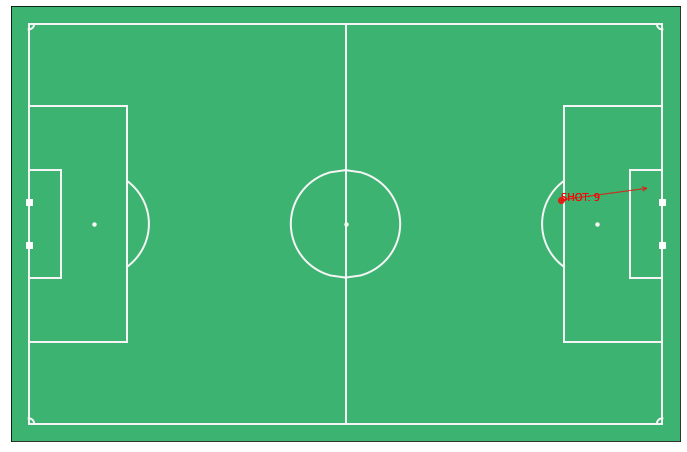

In [159]:
# plot passing move in run up to goal
mviz.plot_events(events_shot_check.loc[1374:1375], indicators = ['Marker','Arrow'], annotate=True )


(<Figure size 864x576 with 1 Axes>, <AxesSubplot:>)

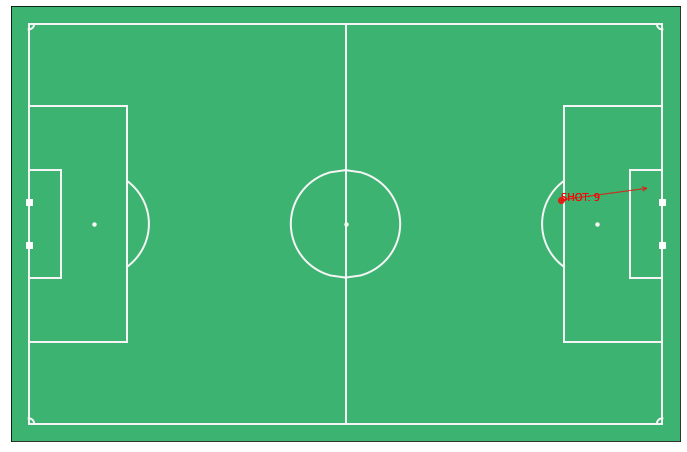

In [132]:
mviz.plot_events(events_shot_check.loc[1465:1466], indicators = ['Marker','Arrow'], annotate=True )

In [160]:
shot_sequence_frames2=shot_sequence_frames1+shot_sequence_frames1
print(len(shot_sequence_frames2))

14448


### Subset the data from the events dataframe to include actions (n<=5) leading to the shot ###

In [161]:
# set up initial path to data
DATADIR = r'C:\Users\Home\Documents\Man City1\sample-data-master\data'
game_id1 = 1 # let's look at sample match 1

# read in tracking data-1
tracking_home1 = mio.tracking_data(DATADIR,game_id1,'Home')
tracking_home1 = mio.to_metric_coordinates(tracking_home1)
tracking_away1 = mio.tracking_data(DATADIR,game_id1,'Away')

tracking_away1 = mio.to_metric_coordinates(tracking_away1)
# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
events_shot1 = mio.to_metric_coordinates(events_shot1)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home1,tracking_away1,events_shot1 = mio.to_single_playing_direction(tracking_home1,tracking_away1,events_shot1)


##############################################################################################################

##################################### Game ID:1 ###################################

##############################################################################################################

### subset data for specific columns ### - xcoords
tracking_home1.columns = tracking_home1.columns.str.lstrip('Home_')
tracking_away1.columns = tracking_away1.columns.str.lstrip('Away_')
tracking_away1=tracking_away1[[c for c in tracking_away1 if c not in ['ball_x','ball_y']]]

xcoords1=tracking_home1.filter(like='_x')
xcoords1=pd.DataFrame(xcoords1.stack(level=0).T).reset_index()
xcoords1.rename(columns = {0:'x','level_1':'Player','level_0':'Frame'}, inplace = True)
xcoords1['Player']=xcoords1['Player'].str.replace('_x','')
### subset data for specific columns ### - ycoords
ycoords1=tracking_home1.filter(like='_y')
ycoords1=pd.DataFrame(ycoords1.stack(level=0).T).reset_index()
ycoords1.rename(columns = {0:'y','level_1':'Player','level_0':'Frame'}, inplace = True)
ycoords1['Player']=ycoords1['Player'].str.replace('_y','')

##### Join both the data frames ######
coords_home=pd.merge(xcoords1,ycoords1,on=['Player','Frame'],how='inner')
coords_home['Team_loc']='Home'
coords_home['game_id']=1

### subset data for specific columns ### - xcoords
xcoords2=tracking_away1.filter(like='_x')
xcoords2=pd.DataFrame(xcoords2.stack(level=0).T).reset_index()
xcoords2.rename(columns = {0:'x','level_1':'Player','level_0':'Frame'}, inplace = True)
xcoords2['Player']=xcoords2['Player'].str.replace('_x','')
### subset data for specific columns ### - ycoords
ycoords2=tracking_away1.filter(like='_y')
ycoords2=pd.DataFrame(ycoords2.stack(level=0).T).reset_index()
ycoords2.rename(columns = {0:'y','level_1':'Player','level_0':'Frame'}, inplace = True)
ycoords2['Player']=ycoords2['Player'].str.replace('_y','')

##### Join both the data frames ######
coords_away=pd.merge(xcoords2,ycoords2,on=['Player','Frame'],how='inner')
coords_away['Team_loc']='Away'
coords_away['game_id']=1

#### Concatenate Two DataFrames ####
Tracking1=pd.concat([coords_home,coords_away], axis=0)
Tracking1=Tracking1.sort_values(by='Frame',ascending=True).reset_index(drop=True)

##### Subset the data based on required shot sequence frames #####
Tracking1_shot=Tracking1[Tracking1['Frame'].isin(shot_sequence_frames)].reset_index(drop=True)


##############################################################################################################

##################################### Game ID:2 ###################################

##############################################################################################################

# set up initial path to data
DATADIR = r'C:\Users\Home\Documents\Man City1\sample-data-master\data'
game_id2 = 2 # let's look at sample match 1

# read in tracking data-1
tracking_home2 = mio.tracking_data(DATADIR,game_id2,'Home')
tracking_home2 = mio.to_metric_coordinates(tracking_home2)
tracking_away2 = mio.tracking_data(DATADIR,game_id2,'Away')
tracking_away2 = mio.to_metric_coordinates(tracking_away2)
# Convert positions from metrica units to meters (note change in Metrica's coordinate system since the last lesson)
events_shot2 = mio.to_metric_coordinates(events_shot2)

# reverse direction of play in the second half so that home team is always attacking from right->left
tracking_home2,tracking_away2,events_shot2 = mio.to_single_playing_direction(tracking_home2,tracking_away2,events_shot2)

### subset data for specific columns ### - xcoords
tracking_home2.columns = tracking_home2.columns.str.lstrip('Home_')
tracking_away2.columns = tracking_away2.columns.str.lstrip('Away_')

xcoords1=tracking_home2.filter(like='_x')
xcoords1=pd.DataFrame(xcoords1.stack(level=0).T).reset_index()
xcoords1.rename(columns = {0:'x','level_1':'Player','level_0':'Frame'}, inplace = True)
xcoords1['Player']=xcoords1['Player'].str.replace('_x','')
### subset data for specific columns ### - ycoords
ycoords1=tracking_home2.filter(like='_y')
ycoords1=pd.DataFrame(ycoords1.stack(level=0).T).reset_index()
ycoords1.rename(columns = {0:'y','level_1':'Player','level_0':'Frame'}, inplace = True)
ycoords1['Player']=ycoords1['Player'].str.replace('_y','')

##### Join both the data frames ######
coords_home=pd.merge(xcoords1,ycoords1,on=['Player','Frame'],how='inner')
coords_home['Team_loc']='Home'
coords_home['game_id']=2

### subset data for specific columns ### - xcoords
xcoords2=tracking_away2.filter(like='_x')
xcoords2=pd.DataFrame(xcoords2.stack(level=0).T).reset_index()
xcoords2.rename(columns = {0:'x','level_1':'Player','level_0':'Frame'}, inplace = True)
xcoords2['Player']=xcoords2['Player'].str.replace('_x','')
### subset data for specific columns ### - ycoords
ycoords2=tracking_away2.filter(like='_y')
ycoords2=pd.DataFrame(ycoords2.stack(level=0).T).reset_index()
ycoords2.rename(columns = {0:'y','level_1':'Player','level_0':'Frame'}, inplace = True)
ycoords2['Player']=ycoords2['Player'].str.replace('_y','')

##### Join both the data frames ######
coords_away=pd.merge(xcoords2,ycoords2,on=['Player','Frame'],how='inner')
coords_away['Team_loc']='Away'
coords_away['game_id']=2

#### Concatenate Two DataFrames ####
Tracking2=pd.concat([coords_home,coords_away], axis=0)
Tracking2=Tracking2.sort_values(by=['Frame','Player'],ascending=True).reset_index(drop=True)

##### Subset the data based on required shot sequence frames #####

Tracking2_shot=Tracking2[Tracking2['Frame'].isin(shot_sequence_frames1)].reset_index(drop=True)


####### Add the two Tracking Datasets ####
Tracking_shot_final=Tracking1_shot.append(Tracking2_shot)

#### Subsetting data only shot freeze frames #####
Shot_Final=Tracking_shot_final[Tracking_shot_final['Frame'].isin(shot_sequence_frames_final)].reset_index(drop=True)

##### Shots to metric coordinates #####
shots1=mio.to_metric_coordinates(shots1)
shots2=mio.to_metric_coordinates(shots2)
tracking_home1,tracking_away1,shots1 = mio.to_single_playing_direction(tracking_home1,tracking_away1,shots1)
tracking_home2,tracking_away2,shots2 = mio.to_single_playing_direction(tracking_home2,tracking_away2,shots2)
shots=shots1.append(shots2).reset_index(drop=True).sort_values(by='shots_sequence_id',ascending=True)

######### Subsetting data to evaluate shots exclusively ##########

zipped = zip(shots['shots_sequence_id'],shots['Start Frame'], shots['End Frame'])

dff = pd.DataFrame([(i, y) for i, s, e in zipped for y in range(s, e+1)],
                   columns=['shots_sequence_id','shotids'])
shot_sequence_frames_final=dff['shotids'].to_list()

#### Merge the Data with the event dataset 

Shot_Final1=pd.merge(Shot_Final,shots,left_on='Frame',right_on='Start Frame',how='left').fillna(method='ffill')
Shot_Final1['Team']=np.where(Shot_Final1['Player']=='ball','Ball',Shot_Final1['Team'])
Shot_Final1['Team_loc']=np.where(Shot_Final1['Player']=='ball','Ball',Shot_Final1['Team_loc'])


def add_ball_xy(result2):

    ball_df = result2[result2['Player'] == 'ball'].reset_index(drop=True)[['Frame', 'x', 'y']]
    ball_df.columns = ['Frame', 'ball_x', 'ball_y']

    result2 = result2.merge(ball_df, on = "Frame")

    return(result2)


def add_distance_to_ball(result2):

    if 'ball_x' in result2.columns:
        result2['distance_to_ball'] = result2[['x', 'y']].sub(np.array( result2[['ball_x', 'ball_y']] )).pow(2).sum(1).pow(0.5)
        result2.distance_to_ball = result2.distance_to_ball.round(2)
        return(result2)

    else:
        print("x||----------------")
        print("Ball x and y coordinates missing - 'add_distance_to_ball' function failed")
        print("Use 'add_ball_xy' to add the missing coordinates")
        print("----------------||x")

def add_distance_to_goals(result2):

    result2['distance_to_goal'] = result2[['x', 'y']].sub(np.array( [0, 0] )).pow(2).sum(1).pow(0.5)
    
    # result2data.distance_to_goal1 = result2data.distance_to_goal1.round(2)
    # result2data.distance_to_goal2 = result2data.distance_to_goal2.round(2)

    return(result2)

Shot_Final1=add_ball_xy(Shot_Final1)
Shot_Final1 = add_distance_to_goals(Shot_Final1)
Shot_Final1=add_distance_to_ball(Shot_Final1)

Shot_Final1['From']=Shot_Final1['From'].str.replace('Player','')

Reading team: home
Reading team: away
Reading team: home
Reading team: away


In [163]:
### Check if the coordinates of both dataset match ###
ball_df = Shot_Final1[Shot_Final1['Team_loc'] == 'Away'].reset_index(drop=True)
ball_df_check=ball_df[(ball_df['y']>=25)]

### Difference between the coordinates in both datasets ###

ball_df['x_diff']=ball_df['x']-ball_df['Start X']
ball_df['y_diff']=ball_df['x']-ball_df['Start Y']

print(max(ball_df.x))
print(min(ball_df.x))
print(max(ball_df['y']))
print(min(ball_df['y']))

print(max(ball_df['Start X']))
print(min(ball_df['Start X']))
print(max(ball_df['Start Y']))
print(min(ball_df['Start Y']))


57.90249999999999
-56.844620000000006
25.619000000000003
-33.533519999999996
50.879999999999995
-48.76
18.36
-18.36


In [169]:
Away_df = Shot_Final1[Shot_Final1['Team_loc'] == 'Away'].reset_index(drop=True)

print(max(Away_df.x))
print(min(Away_df.x))
print(Away_df.x.mean())
print(Away_df['y'].mean())
print(min(Away_df['y']))

54.43736
-54.12466
6.6630761656314705
0.6978665296442689
-32.614160000000005


In [164]:
Shot_Final1.x=np.where(Shot_Final1.x<0,Shot_Final1.x*-1,Shot_Final1.x)
Shot_Final1.x=Shot_Final1.x+

Frame Player         x         y Team_loc  game_id_x  Team  Type  \
1374  135982   ball  38.04658  25.11716     Ball          2  Ball  SHOT   
1375  135982   ball  38.04658  25.11716     Ball          2  Ball  SHOT   
1376  135982   ball  38.04658  25.11716     Ball          2  Ball  SHOT   
1377  135982   ball  38.04658  25.11716     Ball          2  Ball  SHOT   
1378  135982   ball  38.04658  25.11716     Ball          2  Ball  SHOT   
...      ...    ...       ...       ...      ...        ...   ...   ...   
1465  135992   ball  40.21322  25.07772     Ball          2  Ball  SHOT   
1466  135992   ball  40.21322  25.07772     Ball          2  Ball  SHOT   
1467  135992   ball  40.21322  25.07772     Ball          2  Ball  SHOT   
1468  135992   ball  40.21322  25.07772     Ball          2  Ball  SHOT   
1469  135992   ball  40.21322  25.07772     Ball          2  Ball  SHOT   

         Subtype  Period  ...  End X  End Y  game_id_y  shot_id_END  \
1374  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   
1375  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   
1376  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   
1377  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   
1378  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   
...          ...     ...  ...    ...    ...        ...          ...   
1465  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   
1466  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   
1467  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   
1468  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   
1469  OFF TARGET     2.0  ...  50.88   6.12        1.0       1664.0   

     shots_sequence_id  shot_id_START    ball_x    ball_y  distance_to_goal  \
1374              23.0       135722.0  41.64952   4.71036         45.589626   
1375              23.0       135722.0  38.04658  25.11716         45.589626   
1376              23.0       135722.0  38.04658  25.11716         45.589626   
1377              23.0       135722.0  41.64952   4.71036         45.589626   
1378              23.0       135722.0  38.04658  25.11716         45.589626   
...                ...            ...       ...       ...               ...   
1465              23.0       135722.0  40.21322  25.07772         47.391931   
1466              23.0       135722.0  40.21322  25.07772         47.391931   
1467              23.0       135722.0  43.91580   5.05648         47.391931   
1468              23.0       135722.0  40.21322  25.07772         47.391931   
1469              23.0       135722.0  40.21322  25.07772         47.391931   

      distance_to_ball  
1374             20.72  
1375              0.00  
1376              0.00  
1377             20.72  
1378              0.00  
...                ...  
1465              0.00  
1466              0.00  
1467             20.36  
1468              0.00  
1469              0.00  

[66 rows x 28 columns]

In [1]:
from mplsoccer.pitch import Pitch
#%matplotlib widget
import matplotlib.patches as patches
import matplotlib.pyplot as plt

sequence_list1=list(Shot_Final1.shots_sequence_id.unique())
plt.rcParams['axes.facecolor'] = 'White'

for k in sequence_list1:

    frame___ = Shot_Final1[(Shot_Final1['shots_sequence_id'] == k)].reset_index(drop=True)
    Shot_frames=list(frame___.Frame.unique())
    Shot_frames=Shot_frames[0]
    
    frame___=frame___[frame___['Frame']==Shot_frames].reset_index(drop=True)
    
    #### subsetting data for defensive team shape ###

    b_fra = frame___[frame___['Player'] == 'ball'].reset_index(drop=True)
    
    t_fra = frame___[(frame___['Team_loc'] == 'Home')].reset_index(drop=True)
    o_fra = frame___[(frame___['Team_loc'] == 'Away')].reset_index(drop=True)
    

    # print(o_fra)
    pitch = Pitch(pitch_type='statsperform',orientation='horizontal',view='full',layout=(1,1),figsize=(10.8, 7.2),
        pitch_width=68,pitch_length=105,stripe=False,goal_type='line',axis=True,label=True)
    fig, ax = pitch.draw()


    #ax.plot(p_fra.x1, p_fra.y1, 'ko', ms=14,markerfacecolor='blue', zorder=2) #red/maroon
    

    ax.plot(t_fra.x, t_fra.y, 'ko', ms=14,markerfacecolor='black', zorder=2,alpha=1) #red/maroon
    ax.plot(o_fra.x, o_fra.y, 'ko', ms=14,markerfacecolor='red', zorder=1,alpha=0.1) #red/maroon
    ax.plot(b_fra.ball_x, b_fra.ball_y, 'ko', ms=8,markerfacecolor='yellow', zorder=4) #red/maroon

    plt.axvline(x = 24, color = "black",alpha=0.5,ymin=0.05, ymax=0.95)
    #plt.axvline(x=-((tracking_meta['pitch_x'] * 100)/2) + 3000, color = "red")


    #plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) -1500, color = "red")
    #plt.axvline(x=((tracking_meta['pitch_x'] * 100)/2) - 3000, color = "red")
    
    plt.title(str(k))
    
    plt.savefig(r'C:\Users\Home\Documents\xG Shots CFG\Shot_Freeze_Frames/'+'image'+str(k)+'.png')
    
    plt.show()


    # print(p_fra)
    # print(o_fra)

NameError: name 'Shot_Final1' is not defined